## MO444 Project 3 - Reinforcement Learning

* Rodrigo Araújo Marinho Franco - RA: 233569
* Felipe Marinho Tavares - RA: 265680

### Contributions:
* Rodrigo
 * ...
* Felipe
 * ...

# PART I - Evolutionary Model

# PART II - Reinforcement Learning

In [1]:
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

import environment

640
640
Example of environment
Board size:  (11, 20, 1)


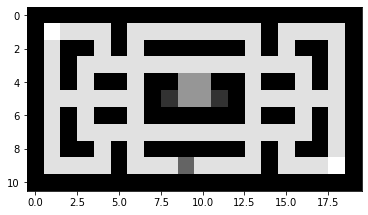

In [2]:
env = environment.Environment(layout="mediumClassic") # smallClassic, mediumClassic, originalClassic

print("Example of environment")
image = env.convert_state_to_image(env.get_current_state())
image = np.moveaxis(image, [0, 1, 2], [-1, -3, -2])
print("Board size: ", image.shape)
plt.imshow(image, cmap="gray", vmax=1, vmin=0)
plt.show()

In [ ]:
wins = []
wins_window = deque(maxlen=200)
scores = []
scores_window = deque(maxlen=200)
average_scores = []

eps_start = 1.0
eps_end = 0.1 # 10%
eps_decay=0.999
eps = eps_start

n_episodes = 3000
print_every = n_episodes/50
for i_episode in range(1, n_episodes + 1):
    env.reset()

    while not env.done():
        env.step(eps)

    eps = max(eps_end, eps_decay*eps)

    scores.append(env.game.state.getScore())
    scores_window.append(env.game.state.getScore())

    wins.append(env.game.state.isWin())
    wins_window.append(env.game.state.isWin())

    average_score = sum(scores_window)/float(len(scores_window))
    winrate = sum(wins_window)/float(len(wins_window)) * 100.0
    average_scores.append(average_score)

    if i_episode % print_every == 0:
        print("Episode: ", i_episode, end=" ")
        print('Average Score: {:.2f}'.format(average_score), end=" ")
        print('Winrate: {:.2f}%'.format(winrate))

plt.figure(figsize=(10, 5))
plt.title("Scores during training")
line1, = plt.plot(scores)
line2, = plt.plot(average_scores)
plt.legend([line1, line2], ["Score", "Average Score"])
plt.show()

Episode:  60 Average Score: -399.62 Winrate: 0.00%
Episode:  120 Average Score: -393.50 Winrate: 0.00%
Episode:  180 Average Score: -397.90 Winrate: 0.00%
Episode:  240 Average Score: -406.36 Winrate: 0.00%
Episode:  300 Average Score: -412.45 Winrate: 0.00%
Episode:  360 Average Score: -415.19 Winrate: 0.00%
Episode:  420 Average Score: -409.38 Winrate: 0.00%
Episode:  480 Average Score: -406.82 Winrate: 0.00%
Episode:  540 Average Score: -392.19 Winrate: 0.00%
Episode:  600 Average Score: -385.80 Winrate: 0.00%
Episode:  660 Average Score: -380.88 Winrate: 0.00%


In [ ]:
state = np.array(list(env.last_actions))[:, 0, :, :]
print(state.shape)
#image = np.moveaxis(state, [0, 1, 2], [-1, -3, -2])
image = state[0]
print("Board size: ", image.shape)
plt.imshow(image, cmap="gray", vmax=1, vmin=0)
plt.show()

image = state[1]
print("Board size: ", image.shape)
plt.imshow(image, cmap="gray", vmax=1, vmin=0)
plt.show()

image = state[2]
print("Board size: ", image.shape)
plt.imshow(image, cmap="gray", vmax=1, vmin=0)
plt.show()

image = state[3]
print("Board size: ", image.shape)
plt.imshow(image, cmap="gray", vmax=1, vmin=0)
plt.show()

In [ ]:
state = np.array(list(env.last_actions_next))[:, 0, :, :]
print(state.shape)
#image = np.moveaxis(state, [0, 1, 2], [-1, -3, -2])
image = state[0]
print("Board size: ", image.shape)
plt.imshow(image, cmap="gray", vmax=1, vmin=0)
plt.show()

image = state[1]
print("Board size: ", image.shape)
plt.imshow(image, cmap="gray", vmax=1, vmin=0)
plt.show()

image = state[2]
print("Board size: ", image.shape)
plt.imshow(image, cmap="gray", vmax=1, vmin=0)
plt.show()

image = state[3]
print("Board size: ", image.shape)
plt.imshow(image, cmap="gray", vmax=1, vmin=0)
plt.show()